In [31]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy as sc
from scipy.optimize import minimize
from scipy.special import gamma
import dynesty
from saveDynesty import saveDynestyChain
import matplotlib.pyplot as plt
from getdist import plots, MCSamples, chains
from getdist import *
from IPython.display import display, Markdown, Latex
# np.seterr('raise')
#%matplotlib
# %matplotlib notebook

N points with $\{L_i\}$, $X_0 = 1$ en cada iteración $X_i -> 1/N$

1- N points Uniform distributed en N-sphere. 

instead $ log L = log L_{max} - 0.5(x- \mu)^T \Sigma^{-1} (x-\mu)$, use:

   $ log L = log L_{max} - \alpha_d X^{2/d}$ 
   
   where $L_{max}$ and $X$ are unknown. 
   
   where d is the dimensionallity



In [2]:
def samplePoint(dims):    
    u = np.random.normal(0, 1, dims)  
    norm = np.sum(u**2)**0.5
    r = np.random.random()**(1.0/dims)
    x = r*u/norm
    return x

def samplingNSphere(npoints, dims):
    return np.array([samplePoint(dims) for i in range(npoints)])

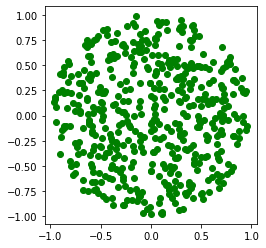

In [3]:
points2d = samplingNSphere(500, 2)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(points2d[:,0], points2d[:,1], c='g')
ax.set_aspect('equal', 'box')

(1000, 3)


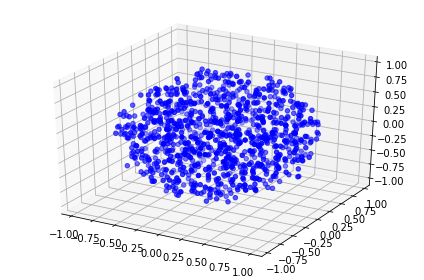

In [4]:
points3d = samplingNSphere(1000, 3)
print(points3d.shape)
fig = plt.figure()
# ax = fig.add_subplot(111,projection='3d')
ax = fig.gca(projection='3d')
plt.tight_layout()
ax.scatter(points3d[:,0], points3d[:,1], points3d[:, 2], c='b')

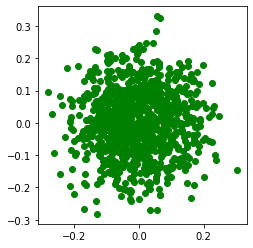

In [5]:
points4d = samplingNSphere(1000, 100)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(points4d[:,0], points4d[:,1], c='g')
ax.set_aspect('equal')
# ax = fig.add_subplot(111)
# ax.scatter(points4d[:,2], points4d[:,3], c='r')
# ax.set_aspect('equal')


- Define a spherical Likelihood:
  $logL = -\frac{x^2}{2\sigma^2}$


In [6]:
sigma = 0.5
def sphereVolume(x):
#     return -x**2/2/sigma**2
    return 4/3*np.pi*np.sum(x**2)**(3/2)

def volNsphere(r, n):
    m = n / 2 + 1
    return r**n * (np.power(np.pi, n/2) / gamma(m))

def sphereLoglike(x):
#     return -x**2/2/sigma**2
    return -np.sum(x**2)/2/sigma**2

propossal fn: $log L = log L_{max} - \alpha_d X^{2/d}$

In [7]:
# def propossalfn(x, logLmax, xMax, alpha, d):
def propossalfn(logLmax, xMax, alpha, d):
    return logLmax - alpha*xMax**(2/d)
#     r = np.sqrt(np.sum(x**2))
#     return logLmax - alpha*volNsphere(r, d)**(2/d)

In [8]:
def logLike(theta, data):
#     points = data[0]
#     likes = data[0]
    loglmax, xMax, alpha, d = theta
    sigma = 0.5
#     chisq = np.sum(((likes - propossalfn(points, loglmax, alpha))/sigma)**2)
    chisq = np.sum(((data - propossalfn(loglmax, xMax, alpha, d))/sigma)**2)
    return 0.5*chisq

Following plots must have the form : $log L = log L_{max} - \alpha_d X^{2/d}$

### 2D

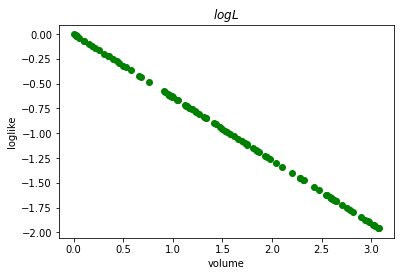

In [9]:
npoints = 100
points2d = samplingNSphere(npoints, 2)
likes2d = np.zeros((npoints, 1))

for i, p in enumerate(points2d):
    likes2d[i] = sphereLoglike(p)
    
volumes2d = np.zeros((npoints, 1))

for i, p in enumerate(points2d):
    r = np.sqrt(np.sum(p**2))
    volumes2d[i] = volNsphere(r, 2)
    # 
#     volumes2d[i] = volNsphere(, 2)
    
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(volumes2d, likes2d, c='g')
ax.set_aspect('equal', 'box')

plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()

### 3D

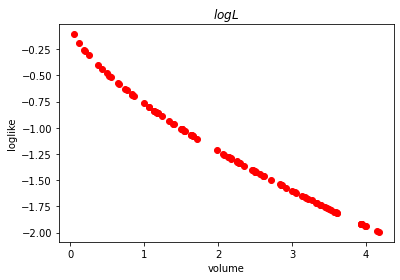

In [10]:
npoints = 100
points3d = samplingNSphere(npoints, 3)
likes3d = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
    likes3d[i] = sphereLoglike(p)
    
    
volumes3d = np.zeros((npoints, 1))

for i, p in enumerate(points3d):
#     volumes3d[i] = sphereVolume(p)
    r = np.sqrt(np.sum(p**2))
    volumes3d[i] = volNsphere(r, 3)
    
plt.scatter(volumes3d, likes3d, c='r')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()    

In [11]:
# saving samples
samples = np.concatenate([points3d, likes3d], axis=1)
idx = 10
print(points3d[idx], likes3d[idx])
samples[idx]

[0.34306992 0.6440855  0.33803364] [-1.29361968]


array([ 0.34306992,  0.6440855 ,  0.33803364, -1.29361968])

Trying to minimize given -loglike and proposal function:

In [12]:
X_max3d = np.max(volumes3d)
tmp_max_logl3d = np.max(likes3d)
print("Current max logl: {}".format(tmp_max_logl3d))
# op = minimize(logLike,  [tmp_max_logl3d, 0.01, 0.5, 1], samples)
op = minimize(logLike,  [tmp_max_logl3d, 0.01, 0.5, 3], samples)
print("Max like: {}, maxX: {}, max alpha: {}, d: {}".format(op.x[0], op.x[1], op.x[2], op.x[3]))

Current max logl: -0.10660647331290027
Max like: -0.2900066836093059, maxX: 0.18225654175210956, max alpha: 0.12781968390884832, d: 3.3071104193120555


Sampling the posterior distribution for this set of live points

In [86]:
sigmaLike = 0.5
logL_bounds = [np.min(likes3d)-sigmaLike, np.max(likes3d)+sigmaLike]
alpha_bounds = [0, 1]
d_bounds = [2, 4]
xMax_bounds = [0, 1]
bounds = [logL_bounds, xMax_bounds, alpha_bounds, d_bounds]
bounds

[[-2.4939376980252814, 0.3933935266870997], [0, 1], [0, 1], [2, 4]]

In [87]:
def priorTransform2(theta):
    points = []
    for c, bound in enumerate(bounds):
        points.append(theta[c]*(bound[1]-bound[0])+bound[0])
    return points

def logLikelihood2(theta):
    return logLike(theta, likes3d)

In [88]:
sampler = dynesty.NestedSampler(logLikelihood2, priorTransform2, 4, bound='multi', sample='slice', nlive=200)
sampler.run_nested(dlogz=0.01)

5011it [00:16, 296.43it/s, +200 | bound: 129 | nc: 1 | ncall: 455368 | eff(%):  1.144 | loglstar:   -inf < 1068.140 <    inf | logz: 1047.759 +/-  0.419 | dlogz:  0.000 >  0.010]


In [89]:
sampler.results.summary()

Summary
nlive: 200
niter: 5011
ncall: 455368
eff(%):  1.144
logz: 1047.759 +/-  0.419


In [90]:
results = sampler.results
saveDynestyChain(results, "outputs/dynestySamples3DBall")


 Number of posterior samples is 5211


In [95]:
filename = '/home/isidro/Documents/gitHub/misRepos/nestedSampling/outputs/dynestySamples3DBall'
mcsamplefile = mcsamples.loadMCSamples(filename, ini=None, jobItem=None, no_cache=False)

mcstats = mcsamplefile.getLikeStats()
for i in range(4):
    print(mcstats.list()[i])
    top = mcstats.names[i].ND_limit_top[1]
    low = mcstats.names[i].ND_limit_bot[1]
    best = mcstats.names[i].bestfit_sample

    print("Best: {:.5}".format(best))
    print("Mean: {:.5}".format(mcsamplefile.getMeans()[i]))
    print("Top value: {:.5}".format(top))
    print("Lower value: {:.5}".format(low))
    print("Std dev: {:.4}".format((mcsamplefile.std(mcstats.list()[i]))))
    print("-"*20)

logL
Best: -2.4568
Mean: -2.4929
Top value: -2.4093
Lower value: -2.4939
Std dev: 0.001119
--------------------
X
Best: 0.96314
Mean: 0.99832
Top value: 1.0
Lower value: 0.87407
Std dev: 0.001701
--------------------
alpha
Best: 0.96333
Mean: 0.99888
Top value: 1.0
Lower value: 0.92381
Std dev: 0.001121
--------------------
d
Best: 3.8825
Mean: 3.1344
Top value: 3.9999
Lower value: 2.0031
Std dev: 0.5569
--------------------


In [ ]:
g = plots.getSubplotPlotter(width_inch=10,
                           analysis_settings={'smooth_scale_2D': 0.5,
                                              'smooth_scale_1D': 0.5})

g.settings.lab_fontsize = 15
g.settings.legend_fontsize = 12
g.settings.axes_fontsize = 12

g.triangle_plot(mcsamplefile,['logL', 'X', 'alpha', 'd'], 
#                 diag1d_kwargs={'colors':['red','blue', 'green']},
#                 colors=['red','blue', 'green'],
#                 legend_labels=['dynesty', 'ownlive'], 
                filled = False, 
                shaded=True)

### 4D

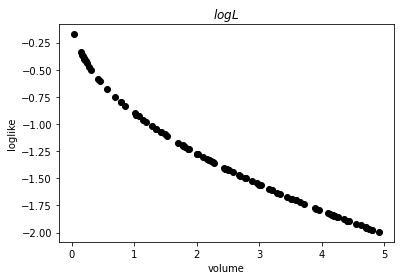

In [20]:
npoints = 100
points4d = samplingNSphere(npoints, 4)
likes4d = np.zeros((npoints, 1))

for i, p in enumerate(points4d):
    likes4d[i] = sphereLoglike(p)
    
volumes4d = np.zeros((npoints, 1))

for i, p in enumerate(points4d):
    r = np.sqrt(np.sum(p**2))
    volumes4d[i] = volNsphere(r, 4)
    
    
plt.scatter(volumes4d, likes4d, c='k')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()
    

In [21]:
# saving samples
samples4d = np.concatenate([points4d, likes4d], axis=1)
idx = 10
print(points4d[idx], likes4d[idx])


#trying to minimize loglike
X_max4d = np.max(volumes4d)
tmp_max_logl4d = np.max(likes4d)
print("Current max logl: {}".format(tmp_max_logl4d))
op = minimize(logLike,  [tmp_max_logl4d, 0.01], samples4d)
print("Max like: {}, max alpha: {}".format(op.x[0], op.x[1]))
# alpha->op.x[1]


[-0.54399759  0.10278712  0.39241949 -0.67710722] [-1.83793162]
Current max logl: -0.17337862245314511


ValueError: not enough values to unpack (expected 4, got 2)

### 5D

In [ ]:
npoints = 100
points5d = samplingNSphere(npoints, 5)
likes5d = np.zeros((npoints, 1))

for i, p in enumerate(points5d):
    likes5d[i] = sphereLoglike(p)
    
volumes5d = np.zeros((npoints, 1))

for i, p in enumerate(points5d):
    #volumes5d[i] = sphereVolume(p)
    r = np.sqrt(np.sum(p**2))
    volumes5d[i] = volNsphere(r, 5)
    
plt.scatter(volumes5d, likes5d, c='y')
plt.xlabel("volume")
plt.ylabel("loglike")
plt.title("$log L $")
plt.show()

In [ ]:
# saving samples
samples5d = np.concatenate([points5d, likes5d], axis=1)
idx = 10
print(points5d[idx], likes5d[idx])


#trying to minimize loglike
X_max5d = np.max(volumes5d)
tmp_max_logl5d = np.max(likes5d)
print("Current max logl: {}".format(tmp_max_logl5d))
op = minimize(logLike,  [tmp_max_logl5d, 0.01], samples5d)
print("Max like: {}, max alpha: {}".format(op.x[0], op.x[1]))
# alpha->op.x[1]
